In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xa
import pandas as pd
import cartopy.crs as ccrs
from pathlib import Path
from tqdm import tqdm


from coralshift import functions_creche
from coralshift.plotting import spatial_plots
from coralshift.processing import spatial_data
from coralshift.dataloading import config

In [3]:
!pwd
# relative path to data directory
data_dir_p = Path(config.data_folder)

/rds/user/rt582/hpc-work/coralshift


# Load data

In [4]:
# specify data resolution
resolution_lat, resolution_lon = 0.25, 0.25
# region of interest
lats = [-34, 0]
lons = [130, 170]
depths = [0, 200]

## Ground Truth – UNEP-WCMC data


In [5]:
# load in shapefile to geopandas dataframe
unep_fp = data_dir_p / "ground_truth/unep_wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
unep_gdf = gpd.read_file(unep_fp)

unep_gdf.head()

,LAYER_NAME,METADATA_I,ORIG_NAME,FAMILY,GENUS,SPECIES,DATA_TYPE,START_DATE,END_DATE,DATE_TYPE,VERIF,NAME,LOC_DEF,SURVEY_MET,GIS_AREA_K,Shape_Leng,Shape_Area,REP_AREA_K,geometry
0,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,Coral line buffered to 300m,Not Reported,5.059916,0.152948,0.000420,Not Reported,"POLYGON ((46.47551 -11.97419, 46.47851 -11.978..."
1,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,Coral line buffered to 300m,Not Reported,5.450101,0.164919,0.000453,Not Reported,"POLYGON ((46.21811 -12.21430, 46.22181 -12.218..."
2,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,31/12/2009,-Y,Not Reported,Not Reported,coral,Not Reported,32.351025,1.079098,0.002664,Not Reported,"MULTIPOLYGON (((142.82287 -9.67503, 142.81353 ..."
3,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,coral,Not Reported,1.823247,0.066740,0.000159,Not Reported,"POLYGON ((36.90715 21.98134, 36.89960 21.98446..."
4,CRR,1.0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,ND,Not Reported,Not Reported,coral,Not Reported,34.815939,1.171056,0.003047,Not Reported,"MULTIPOLYGON (((36.93400 21.98049, 36.93382 21..."


(<Figure size 1000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'Rasterised UNEP Reef Presence'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x1552fb5ae200>)

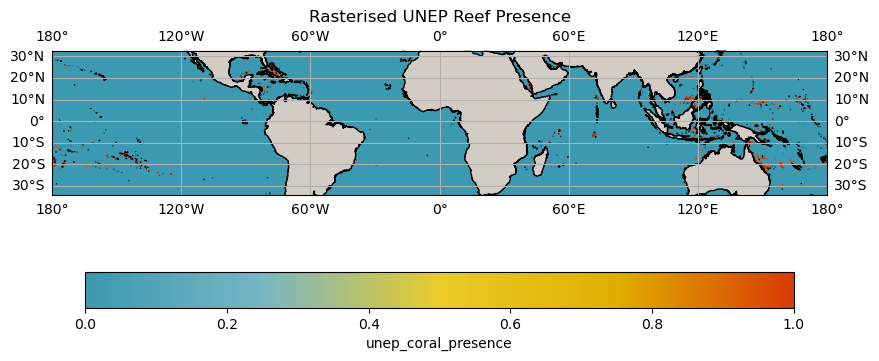

In [6]:
# generate gt raster
unep_raster = functions_creche.rasterize_geodf(unep_gdf, resolution_lat=resolution_lat, resolution_lon=resolution_lon)
# generate gt xarray
xa_unep = functions_creche.raster_to_xarray(
    unep_raster, x_y_limits=functions_creche.lat_lon_vals_from_geo_df(unep_gdf)[:4], 
    resolution_lat=resolution_lat, resolution_lon=resolution_lon, name="unep_coral_presence")

# Plot the xarray DataArray
spatial_plots.plot_spatial(xa_unep, title="Rasterised UNEP Reef Presence", orient_colorbar="horizontal")

# Environmental variables

### CMIP6

In [12]:
# load
cmip6_fp = "/home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos.nc"
cmip6_xa = spatial_data.process_xa_d(xa.open_dataset(cmip6_fp), rename_lat_lon_grids=True)

In [13]:
# TODO: handle with pathlib
# buffer
buffered_fp = Path(cmip6_fp.replace(".nc", "_buffered.nc"))
if not Path.exists(buffered_fp):
    cmip6_buffered_xa = functions_creche.apply_fill_loess(cmip6_xa.isel(depth=0), nx=2, ny=2)
    cmip6_buffered_xa.to_netcdf(cmip6_fp.replace(".nc", "_buffered.nc"))
else:
    print(f"buffered file already exists at {buffered_fp}")
    cmip6_buffered_xa = xa.open_dataset(buffered_fp)

buffered file already exists at /home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_buffered.nc


Text(0.5, 1.0, 'Filled Data')

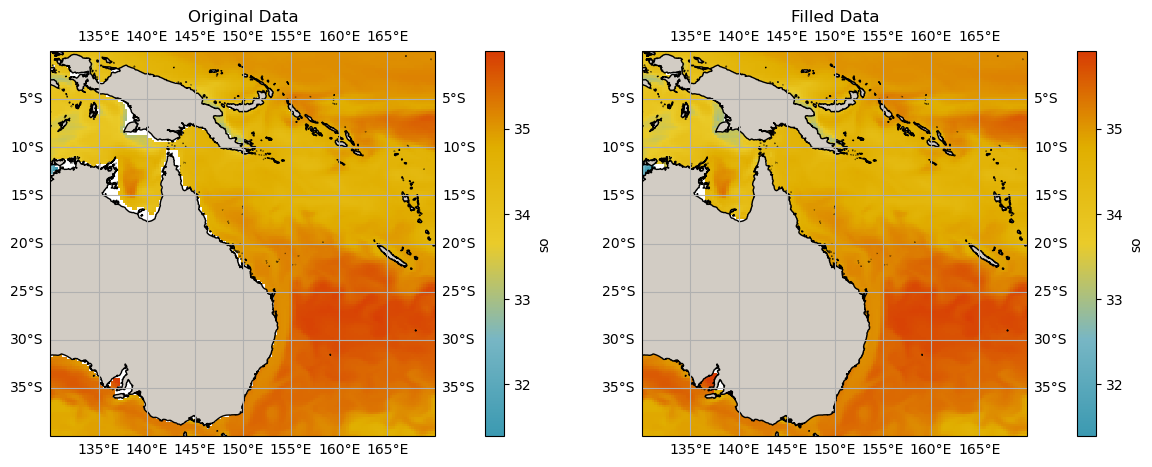

In [ ]:
# f, a = plt.subplots(ncols=2, figsize=(14,5), subplot_kw={"projection": ccrs.PlateCarree()})

# spatial_plots.plot_spatial(cmip6_xa["so"].isel(time=0,depth=0), fax=[f,a[0]])
# a[0].set_title("Original Data");
# spatial_plots.plot_spatial(cmip6_buffered_xa["so"].isel(time=0), fax=[f,a[1]])
# a[1].set_title("Filled Data");

In [14]:
import calendar
# generate comparable temporal parameterisations
from datetime import datetime

def year_to_datetime(year: int, xa_d: xa.DataArray | xa.Dataset = None) -> datetime:
    # TODO: replace with datetime module
    if xa_d:
        # Extract the minimum and maximum years from the dataset's time coordinate
        min_year, max_year = spatial_data.min_max_of_coords(xa_d, "time")

        # Ensure the provided year is within the range of the dataset's time coordinate
        if year < min_year or year > max_year:
            raise ValueError(f"Year {year} is outside the dataset's time range")

    return datetime(year, 1, 1)



def calculate_statistics(
    xa_ds: xa.Dataset, vars: list[str] = ["so", "thetao", "tos", "uo", "vo"], years_window: tuple[int] = None
    ) -> xa.Dataset:
    if years_window:
        # Select the time period of interest
        xa_ds = xa_ds.sel(time=slice(year_to_datetime(min(years_window)), year_to_datetime(max(years_window))))
    
    stats = {}

    if not vars:
        vars = dataset_period.data_vars.keys()

    for i, var_name in tqdm(enumerate(vars), desc=f"calculating statistics for {len(vars)} variables..."):
        var_data = xa_ds[var_name]
        # Calculate annual average
        # annual_mean = var_data.resample(time='1Y').mean()
        # stats[f"{var_name}_am"] = annual_mean

        # Calculate mean for each month
        monthly_mean = var_data.groupby('time.month').mean(dim='time')
        
        # Map numerical month values to month names
        month_names = [calendar.month_name[i] for i in monthly_mean['month'].values]
        
        # Assign monthly means to their respective month names
        for i, month in enumerate(month_names):
            stats[f"{var_name}_{month.lower()}_mean"] = monthly_mean.isel(month=i).values


        # Calculate maximum and minimum of monthly values over the whole time period
        monthly_max_overall = var_data.groupby('time.month').max(dim='time')
        monthly_min_overall = var_data.groupby('time.month').min(dim='time')

        for i, month in enumerate(month_names):
            stats[f"{var_name}_{month.lower()}_max"] = monthly_max_overall.isel(month=i).values
            stats[f"{var_name}_{month.lower()}_min"] = monthly_min_overall.isel(month=i).values

        # Calculate standard deviation of time steps
        time_std = var_data.std(dim='time')
        stats[f"{var_name}_time_std"] = time_std.values

        # Calculate standard deviation of January and July values
        january_std = var_data.where(var_data['time.month'] == 1).std(dim='time')
        july_std = var_data.where(var_data['time.month'] == 7).std(dim='time')
        stats[f"{var_name}_jan_std"] = january_std.values
        stats[f"{var_name}_jul_std"] = july_std.values

        # Calculate the overall mean for each statistic
        stats[f"{var_name}_overall_mean"] = var_data.mean(dim='time').values

    # Combine all calculated variables into a new dataset
    stats_xa = xa.Dataset(
        {key: (('latitude', 'longitude'), value) for key, value in stats.items()},
        coords = {"latitude": var_data.latitude, "longitude": var_data.longitude}
    )

    return stats_xa

years_window = None
stats_xa = calculate_statistics(cmip6_buffered_xa, vars=["so", "thetao", "tos", "uo", "vo"], years_window=years_window)

if years_window:
    years_str = "_".join([str(i) for i in years_window])
    stats_fp = Path(cmip6_fp.replace(".nc", f"_{years_str}_stats.nc"))
else:
    stats_fp = Path(cmip6_fp.replace(".nc", "_stats.nc"))
print(f"saving stats dataset to {stats_fp}...")
stats_xa.to_netcdf(stats_fp)

# load in other relevant environmental data:
# era5 irradiance

# nice-to-haves:
# cyclones
# population

calculating statistics for 5 variables...: 3it [00:01,  1.62it/s]

calculating statistics for 5 variables...: 5it [00:03,  1.62it/s]


saving stats dataset to /home/rt582/rds/hpc-work/coralshift/data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_stats.nc...


### WOA 2018

In [15]:
# WOA gives the statistic e.g. mean for months of each year, over all specified years
xa.open_dataset("/home/rt582/rds/hpc-work/coralshift/data/env_vars/woa/woa_2018/monthly_1981-2010_temp/woa18_decav81B0_t01_01.nc", decode_times=False)

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 57, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) float32 168.5
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    ...                  ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_ma                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

In [16]:
env_data_dir_p = data_dir_p / "env_vars/woa/woa_2018/monthly_1981-2010_temp"


In [17]:
# relevant filepath
env_data_p = env_data_dir_p / "env_vars/woa/woa_2018/monthly_1981-2010_temp"

# TODO: expand to other variables. 
# Could also use open_mfdataset with a preprocess function to limit spatial range: https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html
temp_list = []
# iterate through files in dir ending .nc
for file_p in tqdm(env_data_dir_p.glob("*.nc"), desc=f"Opening .nc files in {env_data_dir_p}"):
    # load in file as xarray dataarray
    temp_array = xa.open_dataset(file_p, decode_times=False)    # TODO: can't understand time format
    # select spatial region of interest
    temp_array = temp_array.sel(lat=slice(*lats), lon=slice(*lons), depth=slice(*depths))   
    # temp_array = temp_array.sel(lat=slice(*lats[::-1]), lon=slice(*lons)) 
    # append to list
    temp_list.append(temp_array)

# concat list of dataarrays into one dataarray. N.B. may not be this simple
env_xa = spatial_data.process_xa_d(xa.concat(temp_list, dim="time"))

Opening .nc files in data/env_vars/woa/woa_2018/monthly_1981-2010_temp: 12it [00:00, 15.40it/s]


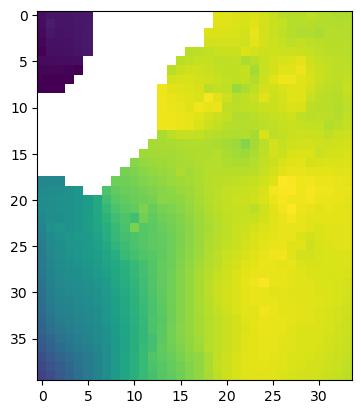

In [18]:
from pyinterp.backends import xarray
from pyinterp import fill

var_data = env_xa["t_an"].isel(depth=0)
grid = xarray.Grid2D(var_data.isel(time=0))
filled = fill.loess(grid, nx=5, ny=5)

plt.imshow(filled)

12 variables to process...


Processing timesteps of variable 't_sd':   0%|          | 0/12 [00:00<?, ?it/s]

Processing timesteps of variable 't_gp': 100%|██████████| 12/12 [00:00<00:00, 32.60it/s]


Text(0.5, 1.0, 'Filled Data')

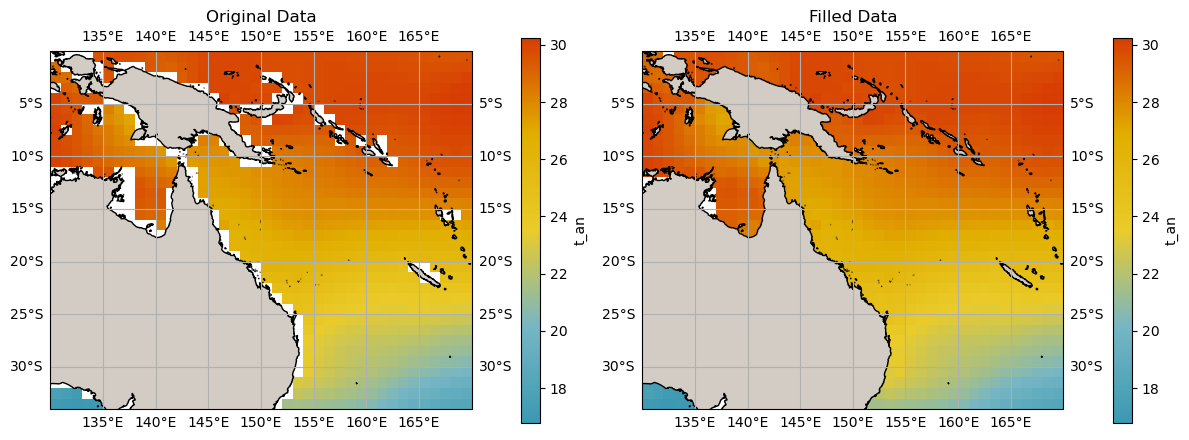

In [19]:
buffered_ds = spatial_data.process_xa_d(
    functions_creche.apply_fill_loess(env_xa.isel(depth=0), nx=2, ny=2))

f, a =plt.subplots(ncols=2, figsize=(14,5), subplot_kw={"projection": ccrs.PlateCarree()})

spatial_plots.plot_spatial(env_xa["t_an"].isel(time=10,depth=0), fax=[f,a[0]])
a[0].set_title("Original Data")
spatial_plots.plot_spatial(buffered_ds["t_an"].isel(time=10), fax=[f,a[1]])
a[1].set_title("Filled Data")


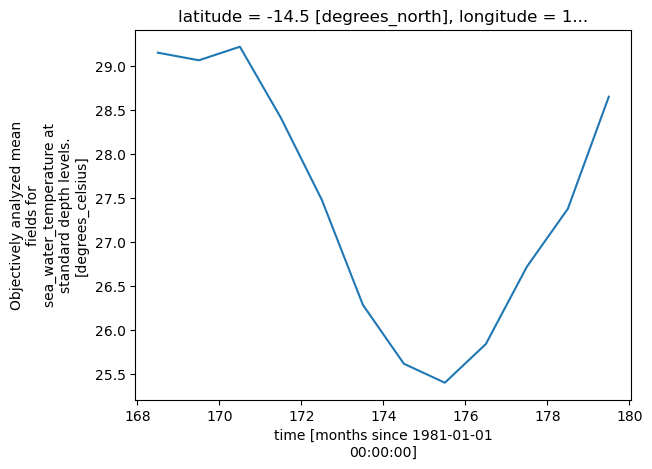

In [20]:
# parameterisation à la Couce et al. 2013

# annual average: t_an
buffered_ds["t_an"].isel(latitude=19, longitude=19).plot()

In [21]:
spatial_data.process_xa_d(buffered_ds).coords

Coordinates:
  * latitude   (latitude) float32 -33.5 -32.5 -31.5 -30.5 ... -2.5 -1.5 -0.5
  * longitude  (longitude) float32 130.5 131.5 132.5 133.5 ... 167.5 168.5 169.5
    depth      float32 0.0
  * time       (time) float32 168.5 169.5 170.5 171.5 ... 177.5 178.5 179.5
    crs        int64 0

In [22]:
xa_unep.coords

Coordinates:
  * latitude   (latitude) float64 32.51 32.26 32.01 31.76 ... -33.8 -34.05 -34.3
  * longitude  (longitude) float64 -180.0 -179.7 -179.5 ... 179.5 179.7 180.0

In [23]:
# generate comparable temporal parameterisations

# load in other relevant environmental data

# era5 irradiance

# oras5 currents

# nice-to-haves:
# cyclones
# population

### ORAS5 Timeseries

# TODO: fix this projection nightmare

oras5_var_dir_p = data_dir_p / "env_vars/oras5/test/annual_sosaline"

# create subdirectory in file directory (if doesn't already exist) with info about region selection
subdir_name = functions_creche.create_coord_subdir_name(oras5_var_dir_p, lats, lons, depths)
create_subdirectory(oras5_var_dir_p, subdir_name)

# for function in directory
for file_p in oras5_var_dir_p.glob("*.nc"):
    # load into xarray
    array = xa.open_dataset(file_p)
    # convert x and y to lat lon
    
    # select region of interest (lats, lons, depths) from open xarray
    # save as .nc file to subdirectory with original name
    # delete original file from main directory

test_xa = xa.open_dataarray(file_p)
test_xa

f, ax = plt.subplots(ncols=2, figsize=(14,5))

test_xa["nav_lat"].plot(ax=ax[0])
test_xa["nav_lon"].plot(ax=ax[1])

import cartopy.crs as ccrs

def polar_axis():
    '''cartopy geoaxes centered at north pole'''
    plt.figure(figsize=(6, 5))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.coastlines(linewidth=0.75, color='black', resolution='50m')
    ax.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    return ax

# # generates <cartopy.mpl.geocollection.GeoQuadMesh at 0x150b260a6ce0> doesn't plot
# ax = polar_axis()
# test_xa.plot.pcolormesh(ax=ax, x="nav_lat", y="nav_lon", transform=ccrs.PlateCarree())

test_xa_rename = test_xa.rename({"nav_lat": "lat", "nav_lon": "lon"})

import os
os.environ["ESMFMKFILE"] = "/home/rt582/rds/.conda/envs/pycoral/lib/esmf.mk"

import xesmf as xe

ds_out = xe.util.grid_global(1, 1)
ds_out


regridder = xe.Regridder(test_xa_rename, ds_out, "bilinear", ignore_degenerate=True)

# remove coordinate values of y for which values of nav_lat < 60
test_xa["y"].where(test_xa["nav_lat"] > 60)

ax = polar_axis()
test_xa.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='nav_lon', y='nav_lat', add_colorbar=False)

# xa.open_dataarray(file_p).isel(deptht=0).plot()
xa.open_dataarray(file_p).plot()

## Bathymetry – GEBCO

In [24]:
# GEBCO
# gebco_f_path = data_dir_p / "bathymetry/gebco/gebco_2023_n-10.0_s-30.0_w140.0_e160.0.nc"
gebco_f_path = data_dir_p / "bathymetry/gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0.nc"
# TODO: processing not working properly e.g. wrt crs
gebco_xa = spatial_data.process_xa_d(xa.open_dataarray(gebco_f_path))
# gebco_nc["elevation"].plot()
# spatial_plots.plot_spatial(gebco_xa)

In [25]:
# calculate slopes. Look in bathymetry.py
from coralshift.dataloading import bathymetry
gebco_slopes_xa = bathymetry.calculate_gradient_magnitude(gebco_xa).rename("seafloor_slope")
# spatial_plots.plot_spatial(gebco_slopes_xa, title="Seafloor gradients")

# save slopes to new file in data dir

/home/rt582/rds/.conda/envs/pycoral/lib/python3.10/site-packages/scipy/ndimage/_filters.py:638: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt(output, output, casting='unsafe')


# Pre-processing

In [26]:
# rename lat and lon to latitude and longitude
# spatially align xarrays
input_dss = [spatial_data.process_xa_d(xa_d) for xa_d in [stats_xa, gebco_xa, gebco_slopes_xa, xa_unep]]

# spatially align datasets into a single xarray dataset
common_dataset = functions_creche.spatially_combine_xa_d_list(input_dss, lats, lons, resolution_lat, resolution_lon)

resampling and merging 4 datasets: 100%|██████████| 4/4 [00:00<00:00,  7.11it/s]


Plotting...:   0%|          | 0/4 [00:00<?, ?it/s]

Plotting...: 100%|██████████| 4/4 [01:00<00:00, 15.23s/it]


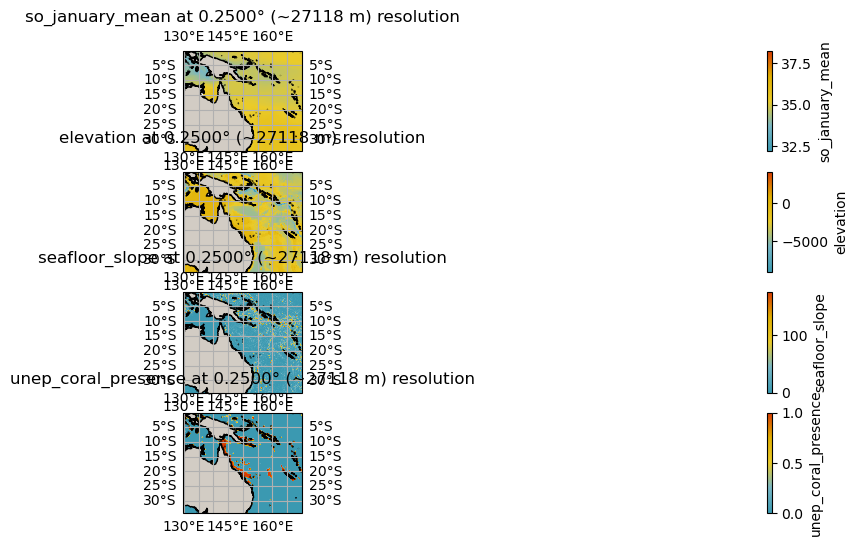

In [27]:
import cartopy.crs as ccrs
# initialise subplots with crs = PlateCarree projection
vars_to_plot = ["so_january_mean", "elevation", "seafloor_slope", "unep_coral_presence"]

f, ax = plt.subplots(nrows=len(vars_to_plot), figsize=(len(vars_to_plot)*15,6), subplot_kw={"projection": ccrs.PlateCarree()})

for i, var in (enumerate(tqdm(vars_to_plot, desc="Plotting..."))):
    array_to_plot = common_dataset[var]
    # if time, select first
    if "time" in array_to_plot.dims:
        array_to_plot = array_to_plot.isel(time=0)
        
    spatial_plots.plot_spatial(array_to_plot, fax=[f,ax[i]])

In [28]:
# f, ax = plt.subplots(ncols=2, figsize=(14,5))

# common_dataset["elevation"].sel(latitude=slice(-30,-28), longitude=slice(155,157)).plot(ax=ax[0])
# ax[0].set_title("elevation")
# common_dataset["t_an"].sel(latitude=slice(-30,-28), longitude=slice(155,157)).isel(time=0).plot(ax=ax[1])
# ax[0].set_title("t_an")

In [29]:
# specify variables to keep
gt = "unep_coral_presence"
# send to dataframe with selected variables
# combined_df = common_dataset[predictors + [gt]].to_dataframe()
# train-test-val split: spatial/pixel-wise


common_df = common_dataset.to_dataframe()

exclude_list = ["crs", "depth", "spatial_ref"]
predictors = [pred for pred in common_df.columns if pred !=gt and pred not in exclude_list]

# generate and save scaling parameters, ignoring nans. Start with min-max scaling
# one-hot encode nans
# cast to numpy array


In [40]:
df_list = functions_creche.tvt_spatial_split(common_df, [0.8, 0, 0.2])

In [44]:
# order = ["train", "test", "val"]

# f,ax = plt.subplots(nrows=3, figsize=(20,5), subplot_kw={"projection": ccrs.PlateCarree()})

# for i, df in enumerate(df_list):
#     ds = xa.Dataset.from_dataframe(df)
#     if "depth" in ds.dims:
#         ds = ds.isel(depth=0)
#     if "time" in ds.dims:
#         ds = ds.isel(time=0)
#     spatial_plots.plot_spatial(ds["so_january_mean"], title=f"{order[i]} dataset", fax=[f,ax[i]])


In [50]:
0 in [0.8,0,0.2]

True

In [52]:
((X_train, y_train), (X_val, y_val), (X_test, y_test)), dfs_list = functions_creche.process_df_for_rfr(common_df, predictors, gt, train_val_test_frac=[0.8,0,0.2])
# vals= process_df_for_rfr(combined_df, predictors, gt)


Batched training:   2%|▏         | 4/175 [00:00<00:17,  9.54it/s]

Batched training: 100%|██████████| 175/175 [00:23<00:00,  7.55it/s]


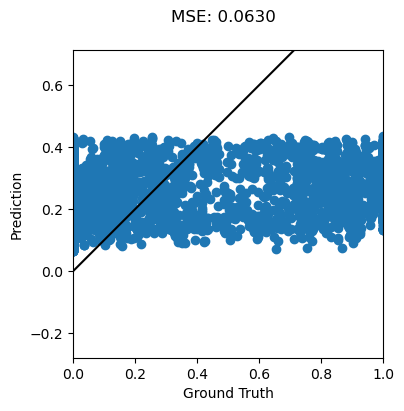

In [64]:
# train model iteratively (using batching)
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor(random_state=42, warm_start=True)

def train_rf_model_iteratively(rf_model, train_X: np.ndarray, train_y: np.ndarray, batch_size: int=100):
    train_points = len(train_X)
    for batch in tqdm(range(0, len(train_X), batch_size), desc=f"Batched training"):
        # if not enough data for a complete batch, use remaining data
        if batch + batch_size > train_points:
            batch_size = train_points - batch

        X_batch = train_X[batch : batch + batch_size]
        y_batch = train_y[batch : batch + batch_size]

        rf_model.fit(X_batch, y_batch)
        rf_model.n_estimators += int(batch_size/2)

    return rf_model

basic_model = train_rf_model_iteratively(rfr_model, X_train, y_train, batch_size=100)
baselines.evaluate_model(basic_model, dfs_list[0], X_train, y_train)

In [54]:
from coralshift.machine_learning import baselines


random_model = baselines.train_tune(
    X_train, y_train, "rf_reg", n_iter=2, cv=2, name="first_random", search_type="random", n_jobs=-1, verbose=0)
# rfr_grid = baselines.rf_search_grid()

# grid_search_cv = baselines.initialise_grid_search(model_type="rf_reg")

Fitting model with a randomized hyperparameter search...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   23.8s


KeyboardInterrupt: 

In [ ]:
# grid search
best_params_dict = random_model.best_params_

grid_model = baselines.train_tune(
    X_train, y_train, "rf_reg", resolution = 1, name="first_grid", search_type="grid", n_jobs=-1, verbose=0, best_params_dict=best_params_dict)

Fitting model with a grid hyperparameter search...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

In [ ]:
y_pred = random_model.predict(X_train)
train_pred_df = functions_creche.reform_df(dfs_list[0], y_pred)

# mean_squared_error(y_train, y_pred)
mean_squared_error(train_pred_df["unep_coral_presence"], train_pred_df["prediction"])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


0.005858808155973494

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


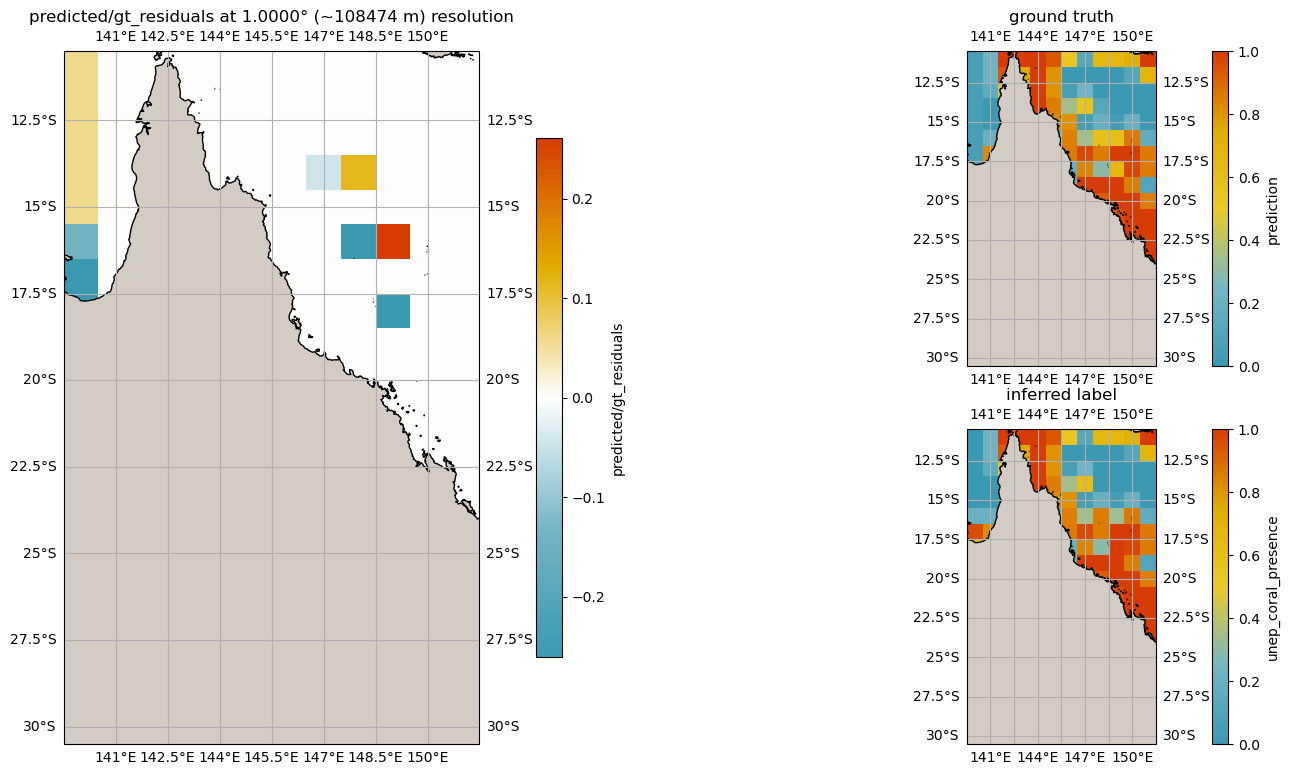

In [ ]:
y_pred = grid_model.predict(X_train)
pred_xa = xa.Dataset.from_dataframe(functions_creche.reform_df(dfs_list[0], y_pred))

spatial_plots.plot_spatial_diffs(
    pred_xa["unep_coral_presence"].isel(time=0), 
    pred_xa["prediction"].isel(time=0), 
    # title="Prediction/Ground Truth Residual"
    )


## PyTorch

In [ ]:
from coralshift.machine_learning import transformer_utils
from coralshift.machine_learning import run_transformer

pyt_train_x, pyt_train_y = transformer_utils.create_dummy_data()
dh = transformer_utils.get_data()

In [ ]:
pyt_train_x.shape

(10000, 12, 1000)

In [ ]:
run_transformer.run_all()

In [ ]:
CMIP6C#####sdjfkl;asdfdh.torch_dataset

In [ ]:
# # TODO: visualise any differences in distributions between train and test/val datasets
# # save scaling parameters to json
# # N.B. this file saving might not be necessary
# from coralshift.utils import file_ops
# file_ops.save_json(scale_dict, data_dir_p / "scaling_params.json")
# # TODO: include more metadata about the exact dataset used to generate the scaling parameters
# # loading scaling data
# import json
# # TODO: smoother way to do this?
# scaling_params_p = data_dir_p / "scaling_params.json"
# f = open(scaling_params_p)
# scale_dict = json.load(f)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


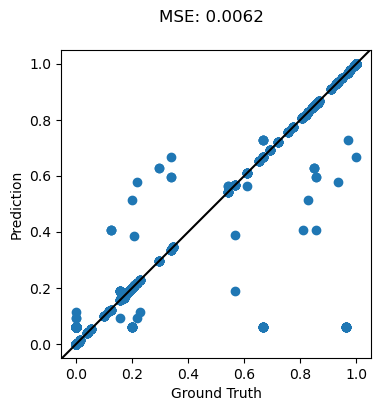

In [ ]:
pred_xa = functions_creche.evaluate_model(grid_model, dfs_list[0], X_train, y_train) 

## Temp Data Visualisations

In [ ]:
common_dataset["unep_coral_presence"].values.flatten().shape

(400,)

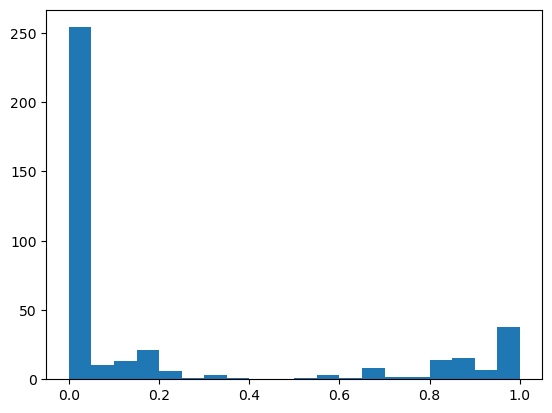

In [ ]:
gts_vals = common_dataset["unep_coral_presence"].values.flatten()
plt.hist(gts_vals, bins=20);

In [ ]:
df_list[0].unep_coral_presence

In [ ]:
df_list[0].unep_coral_presence.plot.hist(bins=100)